<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Загрузка-датасета" data-toc-modified-id="Загрузка-датасета-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка датасета</a></span></li><li><span><a href="#Обзор-датасета" data-toc-modified-id="Обзор-датасета-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Обзор датасета</a></span></li><li><span><a href="#Лемматизации-и-очистка-датасета" data-toc-modified-id="Лемматизации-и-очистка-датасета-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Лемматизации и очистка датасета</a></span></li><li><span><a href="#Визуализация-частоты-употребления-слов:" data-toc-modified-id="Визуализация-частоты-употребления-слов:-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Визуализация частоты употребления слов:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-выборок" data-toc-modified-id="Подготовка-выборок-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка выборок</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия-без-балансировки-на-кросс-валидации:" data-toc-modified-id="Логистическая-регрессия-без-балансировки-на-кросс-валидации:-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Логистическая регрессия без балансировки на кросс-валидации:</a></span></li><li><span><a href="#Логистическая-регрессияс-балансировкой-классов-на-кросс-валидации:" data-toc-modified-id="Логистическая-регрессияс-балансировкой-классов-на-кросс-валидации:-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Логистическая регрессияс балансировкой классов на кросс-валидации:</a></span></li></ul></li><li><span><a href="#SGDClassifier" data-toc-modified-id="SGDClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>SGDClassifier</a></span></li><li><span><a href="#Итоговое-тестирование" data-toc-modified-id="Итоговое-тестирование-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Итоговое тестирование</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Требуется обучить модель классифицировать комментарии на позитивные и негативные. Заказчик предоставил набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

**План выполнения проекта**

1. Загрузим и подготовим данные.
2. Обучим разные модели. 
3. Сделаем выводы и выберем лучшую модель для представления заказчику


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импорт библиотек

In [1]:
import pandas as pd

import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
nltk.download('wordnet')
from tqdm import tqdm
import re
import spacy
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestRegressor
from catboost import cv
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\e.fomin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Загрузка датасета

In [2]:
df = pd.read_csv('toxic_comments.csv', index_col=[0])

### Обзор датасета

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


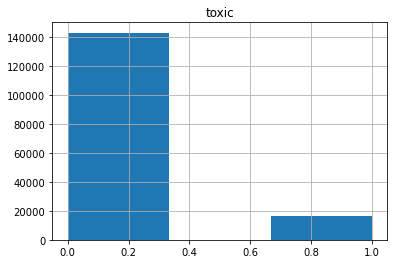

In [4]:
df.hist(bins=3);

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Молодец, исследован баланс классов. Это полезная информация, может пригодиться.</div>

In [5]:
#для логистической регрессии потребуются балансировка классов
display(df['toxic'].value_counts())
class_ratio = df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1]
class_ratio

0    143106
1     16186
Name: toxic, dtype: int64

8.841344371679229

In [6]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

0


### Лемматизации и очистка датасета

Функция для очистки текста от сторонних символов:

In [7]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    return ' '.join(clear_text.split())

In [8]:
df['clear_text'] = df['text'].apply(clear_text)

Загрузим словарь стоп-слов:

Лемматизация:

In [10]:
lemmatizer = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
stopwords = lemmatizer.Defaults.stop_words

def lemmatize(text):
    lemm_list = lemmatizer(text)
    lemmed_text = ' '.join([token.lemma_ for  token in  lemm_list])
    return lemmed_text

In [11]:
tqdm.pandas()
df['lemmed_text'] = df['clear_text'].progress_apply(lemmatize)

100%|██████████| 159292/159292 [22:36<00:00, 117.40it/s]


In [12]:
df.drop(columns=['text', 'clear_text'], axis=1, inplace=True)

### Визуализация частоты употребления слов:

Для визуализации подготовим отдельный корпус из текстов датасета, исключив из него стоп-слова. Визуалаизцию будем проводить путем построения би-грамм через count_vectorizer и библиотеку wordcloud:

In [13]:
corpus = df['lemmed_text'].values

Исключим стоп-слова:

In [14]:
lst=[]
for i in corpus:
    for j in i.split():
        l = []
        if j not in stopwords:
            l.append(j)
    lst.append(i)

Построим график популярности слов в датасете:

In [27]:
words_counter = CountVectorizer(ngram_range=(4, 4))
toxic_count = words_counter.fit_transform(lst)

words_frequence = pd.DataFrame(
  {'word' : words_counter.get_feature_names_out(),

  'frequency' : np.array(toxic_count.sum(axis = 0))[0]
    }).sort_values(by = 'frequency', ascending = False)


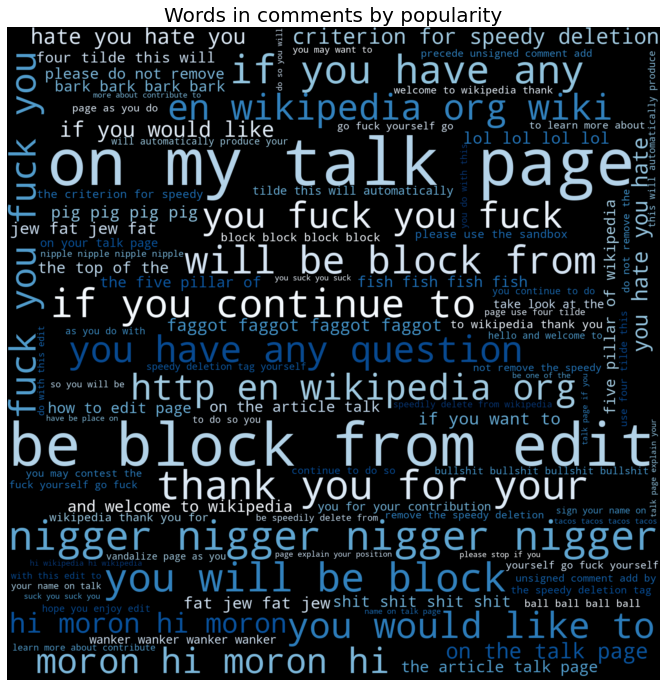

In [28]:
wordcloud_words = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=100,
                               mask=None, 
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(words_frequence.values))


fig, ax = plt.subplots(figsize = (20, 12))


ax.imshow(wordcloud_words, interpolation='bilinear')

ax.set_title('Words in comments by popularity', fontsize = 20)
ax.axis("off")
plt.show()

**Вывод:** 
1. Выполнен обзор датасета. 
2. Данные подготовлены для анализа: лемматизированы, отчищены
3. Выявлен сильный дисбаланс классов 0 и 1 признака "toxic". Соотношение составило 8.84 : 1.

## Обучение

### Подготовка выборок

In [17]:
train, test = train_test_split(df, 
                               test_size = 0.1, 
                               stratify = df['toxic'], 
                               random_state = 282)

train_features = train.drop('toxic', axis=1)
test_features = test.drop('toxic', axis=1)
train_target = train['toxic']
test_target = test['toxic']

### Логистическая регрессия

Ранее в п.1.3 была выявлена отсутствие баланса классов целевого признака. Проверим работу модели с балансировкой и без:

#### Логистическая регрессия без балансировки на кросс-валидации:

Сделаем конвейер Pipeline для tf-idf-векторизации при кросс-валидации

In [18]:
pipeline_lr_disbalanced = Pipeline([
    ('tf-idf vectorizer',  TfidfVectorizer(stop_words=list(stopwords))), 
    ('modelling', LogisticRegression())])

In [19]:
train_f1_disbalanced = cross_val_score(pipeline_lr_disbalanced,
                          train_features['lemmed_text'], 
                          train_target, 
                          cv=5, 
                          scoring='f1').mean()
print('Средняя F1 при CV=5 LogisticRegression с дисбалансом', train_f1_disbalanced)

Средняя F1 при CV=5 LogisticRegression с дисбалансом 0.7408220882002844


#### Логистическая регрессияс балансировкой классов на кросс-валидации:

In [20]:
dict_classes={0: 1, 
              1: class_ratio}

Сделаем конвейер Pipeline для tf-idf-векторизации при кросс-валидации

In [21]:
pipeline_lr = Pipeline([
    ('tf-idf vectorizer',  TfidfVectorizer(stop_words=list(stopwords))), 
    ('modelling', LogisticRegression(class_weight=dict_classes))])

In [22]:
train_f1 = cross_val_score(pipeline_lr,
                          train_features['lemmed_text'], 
                          train_target, 
                          cv=5, 
                          scoring='f1').mean()
print('Средняя F1 при CV=5 LogisticRegression после балансировки', train_f1)

Средняя F1 при CV=5 LogisticRegression после балансировки 0.7566528706402005


Незначительно, но улучшение метрики есть - на 0.017. Используем балансированную версию для поиска оптимальных гиперпараметров через GridSearchCV:

In [33]:
hyperparams = dict(modelling__max_iter = [75, 125, 100],
                modelling__C = [0.5, 1, 10],
                modelling__random_state = [282]
                  )
print()
clf_lr = GridSearchCV(pipeline_lr, 
                   hyperparams, 
                   scoring='f1',
                   cv=3,
                   verbose=2)

clf_lr.fit(train_features['lemmed_text'], train_target)
print('# Tuning hyper-parameters for f1_score')
best_score_LR = clf_lr.best_score_
best_params_LR = clf_lr.best_params_
best_model_LR = clf_lr.best_estimator_

print(f"Best score {best_score_LR} found on development set:")
print()
print(best_params_LR)
print()


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END modelling__C=0.5, modelling__max_iter=75, modelling__random_state=282; total time=  18.2s
[CV] END modelling__C=0.5, modelling__max_iter=75, modelling__random_state=282; total time=  12.1s
[CV] END modelling__C=0.5, modelling__max_iter=75, modelling__random_state=282; total time=  10.2s
[CV] END modelling__C=0.5, modelling__max_iter=125, modelling__random_state=282; total time=  11.4s
[CV] END modelling__C=0.5, modelling__max_iter=125, modelling__random_state=282; total time=  11.4s
[CV] END modelling__C=0.5, modelling__max_iter=125, modelling__random_state=282; total time=  10.4s
[CV] END modelling__C=0.5, modelling__max_iter=100, modelling__random_state=282; total time=  10.7s
[CV] END modelling__C=0.5, modelling__max_iter=100, modelling__random_state=282; total time=  12.9s
[CV] END modelling__C=0.5, modelling__max_iter=100, modelling__random_state=282; total time=  11.5s
[CV] END modelling__C=1, modelling__max_it

Best score 0.7618430678159033 found on development set:

{'modelling__C': 10, 'modelling__max_iter': 100, 'modelling__random_state': 282}

### SGDClassifier

In [35]:
pipeline_sgd = Pipeline([
    ('tf-idf vectorizer',  TfidfVectorizer(stop_words=list(stopwords))), 
    ('modelling', SGDClassifier())])

               
hyperparams = dict(modelling__loss = ['hinge', 'log', 'modified_huber'],
                modelling__learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive'],
                modelling__eta0 = [0.05, 0.1, 0.2],
                modelling__class_weight = [dict_classes],
                modelling__random_state = [282]
                  )

print()
clf_SGD = GridSearchCV(pipeline_sgd, 
                   hyperparams, 
                   scoring='f1',
                   cv=3,
                   verbose=2)

clf_SGD.fit(train_features['lemmed_text'], train_target)
print('# Tuning hyper-parameters for f1_score')
best_score_SGD = clf_SGD.best_score_
best_params_SGD = clf_SGD.best_params_
best_model_SGD = clf_SGD.best_estimator_

print(f"Best score {best_score_SGD} found on development set:")
print()
print(best_params_SGD)
print()


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END modelling__class_weight={0: 1, 1: 8.841344371679229}, modelling__eta0=0.05, modelling__learning_rate=constant, modelling__loss=hinge, modelling__random_state=282; total time=  11.2s
[CV] END modelling__class_weight={0: 1, 1: 8.841344371679229}, modelling__eta0=0.05, modelling__learning_rate=constant, modelling__loss=hinge, modelling__random_state=282; total time=  10.4s
[CV] END modelling__class_weight={0: 1, 1: 8.841344371679229}, modelling__eta0=0.05, modelling__learning_rate=constant, modelling__loss=hinge, modelling__random_state=282; total time=   8.0s
[CV] END modelling__class_weight={0: 1, 1: 8.841344371679229}, modelling__eta0=0.05, modelling__learning_rate=constant, modelling__loss=log, modelling__random_state=282; total time=   9.3s
[CV] END modelling__class_weight={0: 1, 1: 8.841344371679229}, modelling__eta0=0.05, modelling__learning_rate=constant, modelling__loss=log, modelling__random_state=282; total

Best score 0.7588830704382259 found on development set:
best_params_SGD = {'class_weight': {0: 1, 1: 8.841344371679229}, 'eta0': 0.05, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'random_state': 282}

### Итоговое тестирование

Для итогового тестирования отобрана модель LR в связи с ее быстродействием. Параметр f1 у моделей схожий.

CPU times: total: 1.05 s
Wall time: 1.07 s
Метрики LR
ROC AUC: 0.967314132552399
F1 SGDC: 0.7614678899082569


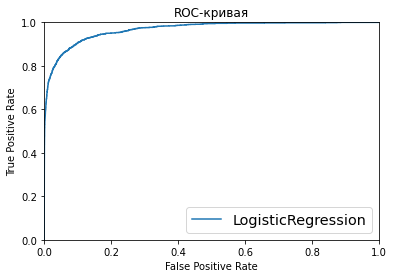

In [58]:
probabilities_test = best_model_LR.predict_proba(test_features['lemmed_text'])
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(test_target, probabilities_one_test)
%time predict_test = best_model_LR.predict(test_features['lemmed_text'])

plt.plot(fpr, tpr, label='LogisticRegression')
print('Метрики LR')
print('ROC AUC:', roc_auc_score(test_target, probabilities_one_test))
print('F1 SGDC:', f1_score(test_target, predict_test))

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

## Выводы

1. Выполнена очистка и лемматизация датасета с отзывами посетителей сайта.
2. Получены векторные представления отзывов 
3. По итогам проверки моделей на тестовой выборке для представления клиенту отобрана модель для классификации отзывов LR с показаталем f1 = 0.761. также построена кривая ROC-AUC с достаточно высоким значением 0.97.